In [1]:
%load_ext autoreload
%autoreload 2

# main libraries and dependencies
import importlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' #matplotlib do not work without it
import torch
from torch import cuda

from scipy.stats import chi2

from data_loader import DataClasses

# Diffusion model trainer function
import trainer
# Diffusion model inference function
from inference import inference_sr, get_sr_model_state, get_scheduler, generate_image

# Classificator model
import classificator

# Experiment function
from experiment_runner import generate_classify_and_calculate

# Some useful functions
import helpers

### 0. Print out important system properties

In [2]:
# Check what version of PyTorch is installed
print(torch.__version__)
# Check the current CUDA version being used
print("CUDA Version: ", torch.version.cuda)

# Check if CUDA is available and if so, print the device name
print("Device name:", torch.cuda.get_device_properties("cuda").name)

# Check if FlashAttention is available
print("FlashAttention available:", torch.backends.cuda.flash_sdp_enabled())

# Check total GPU memory and memory used
gpu_id = 0  # Change this if you have multiple GPUs
total_memory = torch.cuda.get_device_properties(gpu_id).total_memory
reserved_memory = torch.cuda.memory_reserved(gpu_id)
allocated_memory = torch.cuda.memory_allocated(gpu_id)
free_memory = total_memory - reserved_memory - allocated_memory

print(f"Total GPU memory: {total_memory / 1e9:.2f} GB")
print(f"Reserved memory: {reserved_memory / 1e9:.2f} GB")
print(f"Allocated memory: {allocated_memory / 1e9:.2f} GB")
print(f"Free memory : {free_memory / 1e9:.2f} GB")

2.6.0+cu124
CUDA Version:  12.4
Device name: NVIDIA RTX A3000 Laptop GPU
FlashAttention available: True
Total GPU memory: 6.44 GB
Reserved memory: 0.00 GB
Allocated memory: 0.00 GB
Free memory : 6.44 GB


In [3]:
# Set seed to maintain experiment reproducible
helpers.set_seed(23)

In [4]:
# Paths to files
# Dataset locations
image_dir = 'C:/Users/novit/Documents/datasets/best_alzheimer_mri/train'
test_image_dir = 'C:/Users/novit/Documents/datasets/best_alzheimer_mri/test'
# Location to save trained model's weights
ddpm_checkpoint_file = 'ddpm_checkpoints/ddpm_checkpoint_sr_100ep.pth'
classificator_checkpoint_file = 'classificator_checkpoints/classificator_checkpoint_new_01.pth'
# Location to store statistical data
stats_data_file = 'stats/stat_data.json'

## 1. Diffusion model training process
### 1.1. Setting up training hyperparameters

In [5]:
# Hyperparameters
num_steps = 500
crop_size = 64
batch_size = 32
scale_factor = 2
learning_rate = 2e-5
num_epochs = 100

### 1.2. Run the training process

Dataset size: 40960
Number of classes: 3


Epoch 1/50: 100%|██████████| 1280/1280 [09:01<00:00,  2.36it/s]


Epoch 1 | Loss 0.00909


Epoch 2/50: 100%|██████████| 1280/1280 [08:56<00:00,  2.38it/s]


Epoch 2 | Loss 0.00901


Epoch 3/50: 100%|██████████| 1280/1280 [08:53<00:00,  2.40it/s]


Epoch 3 | Loss 0.00898


Epoch 4/50: 100%|██████████| 1280/1280 [08:51<00:00,  2.41it/s]


Epoch 4 | Loss 0.00888


Epoch 5/50: 100%|██████████| 1280/1280 [08:51<00:00,  2.41it/s]


Epoch 5 | Loss 0.00903


Epoch 6/50: 100%|██████████| 1280/1280 [08:51<00:00,  2.41it/s]


Epoch 6 | Loss 0.00891


Epoch 7/50: 100%|██████████| 1280/1280 [08:53<00:00,  2.40it/s]


Epoch 7 | Loss 0.00890


Epoch 8/50: 100%|██████████| 1280/1280 [08:51<00:00,  2.41it/s]


Epoch 8 | Loss 0.00901


Epoch 9/50: 100%|██████████| 1280/1280 [08:52<00:00,  2.40it/s]


Epoch 9 | Loss 0.00906


Epoch 10/50: 100%|██████████| 1280/1280 [08:47<00:00,  2.42it/s]


Epoch 10 | Loss 0.00879


Epoch 11/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 11 | Loss 0.00882


Epoch 12/50: 100%|██████████| 1280/1280 [08:46<00:00,  2.43it/s]


Epoch 12 | Loss 0.00886


Epoch 13/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 13 | Loss 0.00895


Epoch 14/50: 100%|██████████| 1280/1280 [08:46<00:00,  2.43it/s]


Epoch 14 | Loss 0.00883


Epoch 15/50: 100%|██████████| 1280/1280 [08:43<00:00,  2.44it/s]


Epoch 15 | Loss 0.00933


Epoch 16/50: 100%|██████████| 1280/1280 [08:45<00:00,  2.44it/s]


Epoch 16 | Loss 0.00924


Epoch 17/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 17 | Loss 0.00870


Epoch 18/50: 100%|██████████| 1280/1280 [08:46<00:00,  2.43it/s]


Epoch 18 | Loss 0.00827


Epoch 19/50: 100%|██████████| 1280/1280 [08:43<00:00,  2.44it/s]


Epoch 19 | Loss 0.00909


Epoch 20/50: 100%|██████████| 1280/1280 [08:45<00:00,  2.44it/s]


Epoch 20 | Loss 0.00875


Epoch 21/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 21 | Loss 0.00899


Epoch 22/50: 100%|██████████| 1280/1280 [08:45<00:00,  2.43it/s]


Epoch 22 | Loss 0.00898


Epoch 23/50: 100%|██████████| 1280/1280 [08:43<00:00,  2.44it/s]


Epoch 23 | Loss 0.00840


Epoch 24/50: 100%|██████████| 1280/1280 [08:45<00:00,  2.44it/s]


Epoch 24 | Loss 0.00872


Epoch 25/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 25 | Loss 0.00884


Epoch 26/50: 100%|██████████| 1280/1280 [08:46<00:00,  2.43it/s]


Epoch 26 | Loss 0.00875


Epoch 27/50: 100%|██████████| 1280/1280 [08:43<00:00,  2.45it/s]


Epoch 27 | Loss 0.00878


Epoch 28/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 28 | Loss 0.00872


Epoch 29/50: 100%|██████████| 1280/1280 [08:43<00:00,  2.44it/s]


Epoch 29 | Loss 0.00879


Epoch 30/50: 100%|██████████| 1280/1280 [08:45<00:00,  2.43it/s]


Epoch 30 | Loss 0.00864


Epoch 31/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 31 | Loss 0.00873


Epoch 32/50: 100%|██████████| 1280/1280 [08:46<00:00,  2.43it/s]


Epoch 32 | Loss 0.00826


Epoch 33/50: 100%|██████████| 1280/1280 [08:45<00:00,  2.44it/s]


Epoch 33 | Loss 0.00853


Epoch 34/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 34 | Loss 0.00893


Epoch 35/50: 100%|██████████| 1280/1280 [08:43<00:00,  2.45it/s]


Epoch 35 | Loss 0.00837


Epoch 36/50: 100%|██████████| 1280/1280 [08:48<00:00,  2.42it/s]


Epoch 36 | Loss 0.00831


Epoch 37/50: 100%|██████████| 1280/1280 [08:48<00:00,  2.42it/s]


Epoch 37 | Loss 0.00847


Epoch 38/50: 100%|██████████| 1280/1280 [08:48<00:00,  2.42it/s]


Epoch 38 | Loss 0.00890


Epoch 39/50: 100%|██████████| 1280/1280 [08:48<00:00,  2.42it/s]


Epoch 39 | Loss 0.00874


Epoch 40/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 40 | Loss 0.00818


Epoch 41/50: 100%|██████████| 1280/1280 [08:45<00:00,  2.43it/s]


Epoch 41 | Loss 0.00846


Epoch 42/50: 100%|██████████| 1280/1280 [08:44<00:00,  2.44it/s]


Epoch 42 | Loss 0.00880


Epoch 43/50: 100%|██████████| 1280/1280 [08:49<00:00,  2.42it/s]


Epoch 43 | Loss 0.00815


Epoch 44/50: 100%|██████████| 1280/1280 [08:50<00:00,  2.42it/s]


Epoch 44 | Loss 0.00811


Epoch 45/50: 100%|██████████| 1280/1280 [08:50<00:00,  2.41it/s]


Epoch 45 | Loss 0.00888


Epoch 46/50: 100%|██████████| 1280/1280 [08:51<00:00,  2.41it/s]


Epoch 46 | Loss 0.00860


Epoch 47/50: 100%|██████████| 1280/1280 [08:52<00:00,  2.40it/s]


Epoch 47 | Loss 0.00852


Epoch 48/50: 100%|██████████| 1280/1280 [08:49<00:00,  2.42it/s]


Epoch 48 | Loss 0.00858


Epoch 49/50: 100%|██████████| 1280/1280 [08:47<00:00,  2.43it/s]


Epoch 49 | Loss 0.00880


Epoch 50/50: 100%|██████████| 1280/1280 [08:48<00:00,  2.42it/s]


Epoch 50 | Loss 0.00847


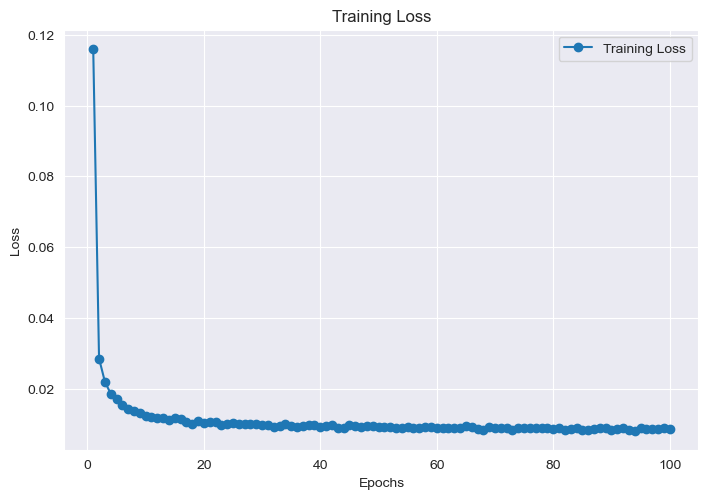

In [5]:
cuda.empty_cache()
trainer.train_sr(
    image_dir=image_dir,
    crop_size=crop_size,
    scale_factor=scale_factor,
    batch_size=batch_size,
    lr=learning_rate,
    num_time_steps=num_steps,
    num_epochs=num_epochs,
    checkpoint_path='ddpm_checkpoints/ddpm_checkpoint_sr.pth',
    file_to_save=ddpm_checkpoint_file,
)

### 1.3. Run the inference to produce super-resolved images

In [8]:
# Load some images from dataset to make inference
crop_size = 128
num_images = 10  # number images to load
# Load and log the first 10 elements from the DataLoader
# lrs - Low-resolution images list
# hrs - Hi-resolution images list
# clss - List of ground true class of images
lrs, hrs, clss = helpers.image_loader(
    image_dir=test_image_dir,
    num_images=num_images,
    crop_size=crop_size,
    scale_factor=scale_factor,
)

In [6]:
# Some magic to make everything work seamlessly
from torch import cuda
cuda.empty_cache()

In [8]:
# Images to show (up to 10)
num_images = 3
assert len(lrs) >= num_images, 'Up to {len(lrs)} images can be shown!'
# loading saved model weight
# model = get_sr_model_state('ddpm_checkpoints/ddpm_checkpoint_sr_1750339897.472253', num_classes=5)
model = get_sr_model_state(ddpm_checkpoint_file, num_classes=3)
# creating scheduler
scheduler = get_scheduler(num_steps)
generated_images = []
# Get "null" class for guideless inference
null_class = torch.tensor([DataClasses.get_null_class_index(DataClasses)])
# generating image examples (will take some time)
for idx in range(num_images):
    generated_image = generate_image(128, lrs[idx], null_class, model, scheduler, num_steps)
    generated_images.append(generated_image)
    cuda.empty_cache()


### 1.4 Show images side-by-side: low-res, hi-res, bicubic upscaled low-res and super-res

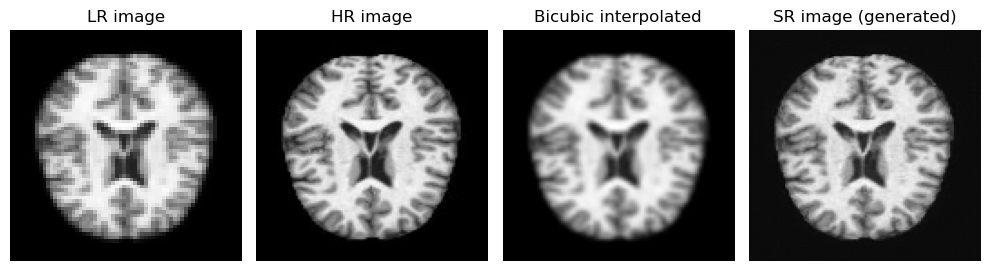

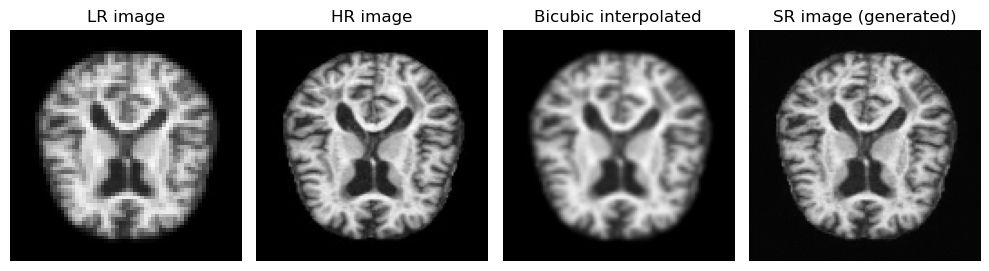

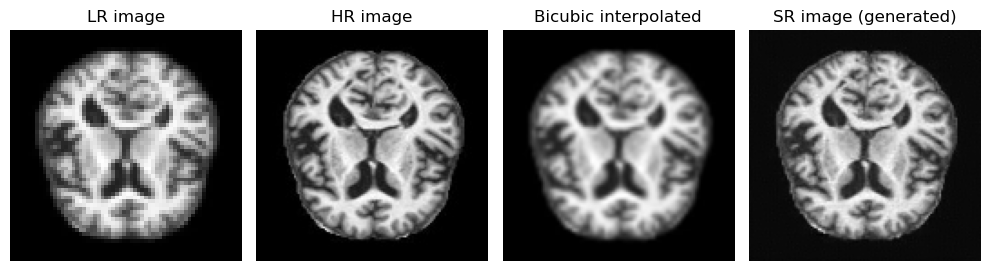

In [9]:
# display generated SR images
for idx in range(num_images):
    helpers.show_images(lrs[idx], hrs[idx], generated_images[idx].squeeze(0))

## 2. Classificator model training process
### 2.1. Set up training hyperparameters

In [10]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda.empty_cache()
# Hyperparameters
batch_size = 256
learning_rate = 0.00001
num_epochs = 35 # 35 is optimal for alzheimer dataset TODO with smaller learning rate need to train more than 20
crop_size = 128

### 2.2. Running the training process

Epoch [1/35], Train Loss: 0.5589, Train Accuracy: 0.7170, Valid Loss: 0.7395, Valid Accuracy: 0.5403, 
Epoch [2/35], Train Loss: 0.3665, Train Accuracy: 0.8563, Valid Loss: 0.5193, Valid Accuracy: 0.7404, 
Epoch [3/35], Train Loss: 0.2985, Train Accuracy: 0.8811, Valid Loss: 0.4941, Valid Accuracy: 0.7568, 
Epoch [4/35], Train Loss: 0.2523, Train Accuracy: 0.8975, Valid Loss: 0.4585, Valid Accuracy: 0.7873, 
Epoch [5/35], Train Loss: 0.2115, Train Accuracy: 0.9186, Valid Loss: 0.4226, Valid Accuracy: 0.7959, 
Epoch [6/35], Train Loss: 0.1855, Train Accuracy: 0.9306, Valid Loss: 0.3833, Valid Accuracy: 0.8264, 
Epoch [7/35], Train Loss: 0.1530, Train Accuracy: 0.9512, Valid Loss: 0.3617, Valid Accuracy: 0.8342, 
Epoch [8/35], Train Loss: 0.1231, Train Accuracy: 0.9639, Valid Loss: 0.3409, Valid Accuracy: 0.8405, 
Epoch [9/35], Train Loss: 0.1020, Train Accuracy: 0.9730, Valid Loss: 0.3144, Valid Accuracy: 0.8514, 
Epoch [10/35], Train Loss: 0.0818, Train Accuracy: 0.9812, Valid Loss: 0.

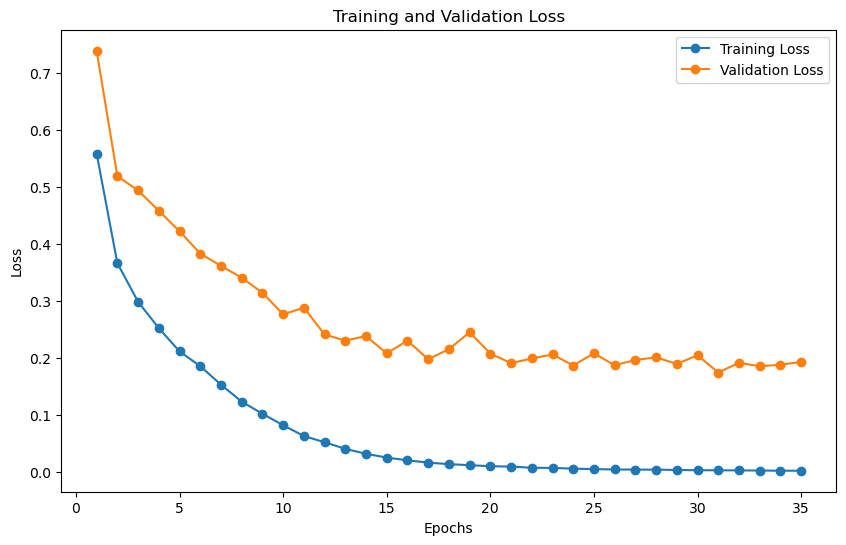

In [11]:
classificator.trainer(
    train_image_dir=image_dir,
    val_image_dir=test_image_dir,
    num_epochs=num_epochs,
    batch_size=batch_size,
    crop_size=crop_size,
    learning_rate=learning_rate,
    device=device,
    file_to_save=classificator_checkpoint_file,
)

### 2.3. Run classificator to evaluate previously generated images

In [7]:
# Loading saved classificator's weights and instantiating classificator instance
# classificator_checkpoint_path = 'classifier_models\\classification_model1750175641.079124.pth'
model = classificator.get_model_state(classificator_checkpoint_file, num_classes=2)
# evaluating images previously generated by diffusion model in 1.3.
predicted_cls_idxs = []
for idx in range(num_images):
    predicted_cls_idxs.append(classificator.classify_image(model, generated_images[idx]))
for idx in range(num_images):
    print(f'Image true class: {clss[idx][0]} \tGenerated image predicted class: {predicted_cls_idxs[idx]}')

NameError: name 'num_images' is not defined

## 3. Experiment
### 3.1. Set parameters

In [13]:
# Paths to files - repeated for convenience
# Dataset locations
test_image_dir = 'C:/Users/novit/Documents/datasets/best_alzheimer_mri/test'
# Location to save trained model's weights
ddpm_checkpoint_file = 'ddpm_checkpoints/ddpm_checkpoint_sr_100ep.pth'
classificator_checkpoint_file = 'classificator_checkpoints/classificator_checkpoint.pth'
# Location to store statistical data
stats_data_file = 'stats/stat_data.json'

### 3.2. Run experiment to generate and classify images

In [9]:
cuda.empty_cache()
stats_data = generate_classify_and_calculate(
    test_image_dir,
    ddpm_checkpoint_file,
    classificator_checkpoint_file,
    save_path=stats_data_file,
    batch_size=1
    )

Processing test dataset: 100%|██████████| 1279/1279 [5:18:07<00:00, 14.92s/it]  


### 3.3. Display achieved metrics

In [10]:
# Read saved statistical data object
try:
    stats_data
except NameError:
    stats_data = helpers.load_json(stats_data_file)

# unpack statistical data from data object
mcnemar_stats = stats_data['mcnemar_stats']

base_stats_data = stats_data['base_stats_data']
is_correct_predictions = stats_data['is_correct_predictions']

# true image classes
image_classes = base_stats_data['image_classes']
# predicted true image class
ground_truth_predictions = base_stats_data['ground_truth_predictions']
# predicted generated image class
generated_predictions = base_stats_data['generated_predictions']

# Two sets of images predicted classification
is_correct_ground_true_predictions = is_correct_predictions['is_correct_ground_true_predictions']
is_correct_generated_predictions = is_correct_predictions['is_correct_generated_predictions']


In [11]:
is_correct_ground_true_predictions = []
is_correct_generated_predictions = []
for idx, cls in enumerate(image_classes):
    is_correct_ground_true_predictions.append(ground_truth_predictions[idx]==cls)
    is_correct_generated_predictions.append(generated_predictions[idx]==cls)

print(sum(is_correct_ground_true_predictions))
print(sum(is_correct_generated_predictions))


1225
1196


#### 3.3.1 Contingency table for McNemar test

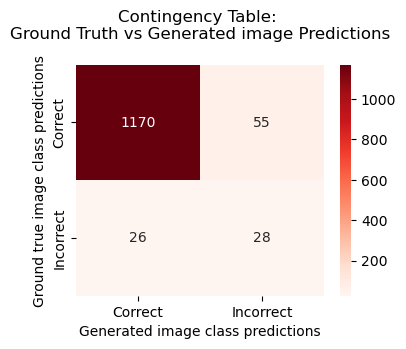

In [12]:
importlib.reload(helpers)
ct_df = helpers.show_conf_matrix(
    is_correct_ground_true_predictions,
    is_correct_generated_predictions,
    title='Contingency Table: \nGround Truth vs Generated image Predictions\n',
    indexes=['Correct', 'Incorrect'],
    columns=['Correct', 'Incorrect'],
    xlabel='Generated image class predictions',
    ylabel='Ground true image class predictions',
    color='Reds'
)

In [13]:
# Access the values from the DataFrame
a = ct_df.loc['Correct', 'Correct']
b = ct_df.loc['Correct', 'Incorrect']
c = ct_df.loc['Incorrect', 'Correct']
d = ct_df.loc['Incorrect', 'Incorrect']
# Printing variables for calculate McNemar chi2
print(f"a: {a}")
print(f"b: {b}")
print(f"c: {c}")
print(f"d: {d}")

a: 1170
b: 55
c: 26
d: 28


#### 3.3.2 McNemar chi-squared and p-value

In [14]:
# Perform the McNemar test
result = (b-c)**2/(b+c)

# Table dimensionality
rows, cols = ct_df.shape

# Calculate degree of freedom
degree_of_freedom = (rows - 1)*(cols - 1)

# Calculate p-value from the chi-squared statistic
p_value = chi2.sf(result, df=degree_of_freedom)

print("McNemar's Test Results:")
print(f"Chi-squared statistic: \t{result:.3f}")
print(f"P-value: \t\t\t\t{p_value}")

McNemar's Test Results:
Chi-squared statistic: 	10.383
P-value: 				0.0012720043792379132


#### 3.3.3 Confusion matrix and metrics for Ground true image classifications

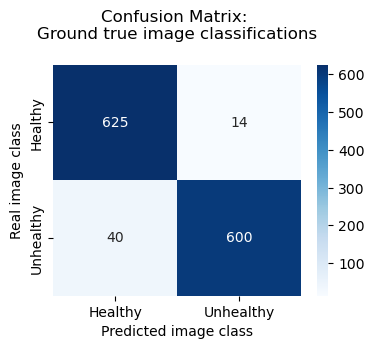

In [15]:
true_cm_df = helpers.show_conf_matrix(
    image_classes,
    ground_truth_predictions,
    title='Confusion Matrix: \nGround true image classifications\n',
    indexes=['Healthy', 'Unhealthy'],
    columns=['Healthy', 'Unhealthy'],
    xlabel='Predicted image class',
    ylabel='Real image class',
)

In [16]:
# Access the values from the DataFrame
TN = true_cm_df.loc['Healthy', 'Healthy']
FP = true_cm_df.loc['Healthy', 'Unhealthy']
FN = true_cm_df.loc['Unhealthy', 'Healthy']
TP = true_cm_df.loc['Unhealthy', 'Unhealthy']

print(f"True Positives (TP): \t{TP}")
print(f"False Negatives (FN): \t{FN}")
print(f"False Positives (FP): \t{FP}")
print(f"True Negatives (TN): \t{TN}")

True Positives (TP): 	600
False Negatives (FN): 	40
False Positives (FP): 	14
True Negatives (TN): 	625


In [17]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
FNR = FN/(TN+FP)

print(f"True image classification metrics:")
print(f"  Accuracy: \t{accuracy:.3f}")
print(f"  Precision: \t{precision:.3f}")
print(f"  Recall: \t\t{recall:.3f}")
print(f"  FNR: \t\t\t{FNR:.3f}")

True image classification metrics:
  Accuracy: 	0.958
  Precision: 	0.977
  Recall: 		0.938
  FNR: 			0.063


#### 3.3.4 Confusion matrix and metrics for Generated image classifications

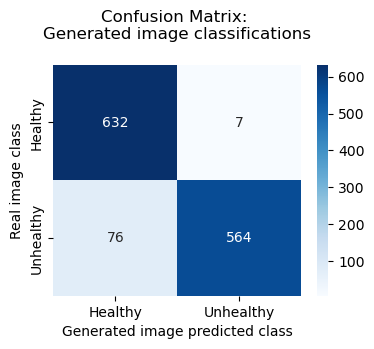

In [18]:
# Generated image classification confusion matrix
gen_cm_df = helpers.show_conf_matrix(
    image_classes,
    generated_predictions,
    title='Confusion Matrix: \nGenerated image classifications\n',
    indexes=['Healthy', 'Unhealthy'],
    columns=['Healthy', 'Unhealthy'],
    xlabel='Generated image predicted class',
    ylabel='Real image class',
)

In [19]:
# Access the values from the DataFrame
TN = gen_cm_df.loc['Healthy', 'Healthy']
FP = gen_cm_df.loc['Healthy', 'Unhealthy']
FN = gen_cm_df.loc['Unhealthy', 'Healthy']
TP = gen_cm_df.loc['Unhealthy', 'Unhealthy']

print(f"True Positives (TP): \t{TP}")
print(f"False Negatives (FN): \t{FN}")
print(f"False Positives (FP): \t{FP}")
print(f"True Negatives (TN): \t{TN}")

True Positives (TP): 	564
False Negatives (FN): 	76
False Positives (FP): 	7
True Negatives (TN): 	632


In [20]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
FNR = FN/(TN+FP)

print(f"Generated image classification metrics:")
print(f"  Accuracy: \t{accuracy:.3f}")
print(f"  Precision: \t{precision:.3f}")
print(f"  Recall: \t\t{recall:.3f}")
print(f"  FNR: \t\t\t{FNR:.3f}")

Generated image classification metrics:
  Accuracy: 	0.935
  Precision: 	0.988
  Recall: 		0.881
  FNR: 			0.119
